In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_readme.md
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_metadata.csv
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (59).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (181).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (104).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (118).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (47).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (135).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Mel

In [13]:
!pip install thop


In [14]:
# ===============================================================
# 🔰 লাইব্রেরি ইমপোর্ট
# ===============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
from tqdm import tqdm
import os, time
from thop import profile  # GFLOPs



In [15]:
# ===============================================================
# 🔰 GPU ব্যবহার
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




Using device: cuda


In [16]:
# ===============================================================
# 🔰 ডেটাসেট লোকেশন (নিজের পথটি দিন)
# ===============================================================
DATA_DIR ="/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes"
# ===============================================================
# 🔰 ডেটা ট্রান্সফর্মেশন
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [17]:
# ===============================================================
# 🔰 ImageFolder দিয়ে ডেটা লোড করা
# ===============================================================
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ===============================================================
# 🔰 Train/Test বিভাজন 60:40
# ===============================================================
test_ratio = 0.4
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 610, Test: 406


In [18]:
# ===============================================================
# 🔰 Train সেটের মধ্যে থেকে ১০% validation আলাদা করা
# ===============================================================
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 549, Validation: 61, Test: 406


In [19]:
# ===============================================================
# 🔰 DataLoader সেটআপ
# ===============================================================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# ===============================================================
# 🔰 Model setup
# ===============================================================
model = models.resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
# ===============================================================
# 🔰 Training functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [22]:
# ===============================================================
# 🔰 Training loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")


Epoch 1/50


Train Loss: 1.8250, Acc: 0.3898 | Val Loss: 1.2597, Acc: 0.6230

Epoch 2/50


Train Loss: 0.7249, Acc: 0.8434 | Val Loss: 0.6192, Acc: 0.8197

Epoch 3/50


Train Loss: 0.2764, Acc: 0.9472 | Val Loss: 0.4929, Acc: 0.8852

Epoch 4/50


Train Loss: 0.1418, Acc: 0.9727 | Val Loss: 0.4616, Acc: 0.8852

Epoch 5/50


Train Loss: 0.0970, Acc: 0.9818 | Val Loss: 0.4142, Acc: 0.8852

Epoch 6/50


Train Loss: 0.0927, Acc: 0.9727 | Val Loss: 0.4927, Acc: 0.8033

Epoch 7/50


Train Loss: 0.1237, Acc: 0.9800 | Val Loss: 0.4170, Acc: 0.9016

Epoch 8/50


Train Loss: 0.0556, Acc: 0.9927 | Val Loss: 0.5048, Acc: 0.8361

Epoch 9/50


Train Loss: 0.0498, Acc: 0.9927 | Val Loss: 0.3805, Acc: 0.8852

Epoch 10/50


Train Loss: 0.0718, Acc: 0.9818 | Val Loss: 0.4655, Acc: 0.8525

Epoch 11/50


Train Loss: 0.0544, Acc: 0.9854 | Val Loss: 0.7539, Acc: 0.8033

Epoch 12/50


Train Loss: 0.0695, Acc: 0.9800 | Val Loss: 0.6133, Acc: 0.8033

Epoch 13/50


Train Loss: 0.0850, Acc: 0.9854 | Val Loss: 0.6002, Acc: 0.8197

Epoch 14/50


Train Loss: 0.0666, Acc: 0.9872 | Val Loss: 0.5798, Acc: 0.8689

Epoch 15/50


Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 0.7307, Acc: 0.7869

Epoch 16/50


Train Loss: 0.0424, Acc: 0.9909 | Val Loss: 0.6603, Acc: 0.7705

Epoch 17/50


Train Loss: 0.0251, Acc: 0.9927 | Val Loss: 0.8124, Acc: 0.7541

Epoch 18/50


Train Loss: 0.0338, Acc: 0.9909 | Val Loss: 0.6733, Acc: 0.8361

Epoch 19/50


Train Loss: 0.0450, Acc: 0.9872 | Val Loss: 1.0584, Acc: 0.7541

Epoch 20/50


Train Loss: 0.1375, Acc: 0.9654 | Val Loss: 0.5623, Acc: 0.8361

Epoch 21/50


Train Loss: 0.0594, Acc: 0.9836 | Val Loss: 0.8001, Acc: 0.7705

Epoch 22/50


Train Loss: 0.0711, Acc: 0.9836 | Val Loss: 0.7955, Acc: 0.7869

Epoch 23/50


Train Loss: 0.1255, Acc: 0.9690 | Val Loss: 0.8759, Acc: 0.7377

Epoch 24/50


Train Loss: 0.1198, Acc: 0.9599 | Val Loss: 0.7184, Acc: 0.7377

Epoch 25/50


Train Loss: 0.0667, Acc: 0.9854 | Val Loss: 0.5446, Acc: 0.8033

Epoch 26/50


Train Loss: 0.0739, Acc: 0.9763 | Val Loss: 0.7789, Acc: 0.7541

Epoch 27/50


Train Loss: 0.0422, Acc: 0.9927 | Val Loss: 0.7490, Acc: 0.7705

Epoch 28/50


Train Loss: 0.0240, Acc: 0.9982 | Val Loss: 0.6331, Acc: 0.8361

Epoch 29/50


Train Loss: 0.0351, Acc: 0.9909 | Val Loss: 0.6896, Acc: 0.7869

Epoch 30/50


Train Loss: 0.1063, Acc: 0.9781 | Val Loss: 0.6860, Acc: 0.8197

Epoch 31/50


Train Loss: 0.0424, Acc: 0.9891 | Val Loss: 0.5169, Acc: 0.8197

Epoch 32/50


Train Loss: 0.0359, Acc: 0.9909 | Val Loss: 0.3891, Acc: 0.8689

Epoch 33/50


Train Loss: 0.0161, Acc: 0.9964 | Val Loss: 0.3642, Acc: 0.9016

Epoch 34/50


Train Loss: 0.0108, Acc: 1.0000 | Val Loss: 0.3857, Acc: 0.8689

Epoch 35/50


Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.3683, Acc: 0.8852

Epoch 36/50


Train Loss: 0.0229, Acc: 0.9964 | Val Loss: 0.5213, Acc: 0.8689

Epoch 37/50


Train Loss: 0.0241, Acc: 0.9909 | Val Loss: 0.5084, Acc: 0.8689

Epoch 38/50


Train Loss: 0.0985, Acc: 0.9745 | Val Loss: 0.7990, Acc: 0.7377

Epoch 39/50


Train Loss: 0.0704, Acc: 0.9818 | Val Loss: 0.6658, Acc: 0.8361

Epoch 40/50


Train Loss: 0.0261, Acc: 0.9945 | Val Loss: 0.6286, Acc: 0.8197

Epoch 41/50


Train Loss: 0.0247, Acc: 0.9909 | Val Loss: 0.5078, Acc: 0.8525

Epoch 42/50


Train Loss: 0.0211, Acc: 0.9945 | Val Loss: 0.3843, Acc: 0.9016

Epoch 43/50


Train Loss: 0.0151, Acc: 1.0000 | Val Loss: 0.4116, Acc: 0.8852

Epoch 44/50


Train Loss: 0.0094, Acc: 1.0000 | Val Loss: 0.4569, Acc: 0.8852

Epoch 45/50


Train Loss: 0.0060, Acc: 1.0000 | Val Loss: 0.4253, Acc: 0.8852

Epoch 46/50


Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.3704, Acc: 0.8689

Epoch 47/50


Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.3455, Acc: 0.9180

Epoch 48/50


Train Loss: 0.0132, Acc: 0.9964 | Val Loss: 0.5049, Acc: 0.8852

Epoch 49/50


Train Loss: 0.0410, Acc: 0.9909 | Val Loss: 0.5386, Acc: 0.8361

Epoch 50/50


Train Loss: 0.0358, Acc: 0.9836 | Val Loss: 0.3632, Acc: 0.8852

✅ Total training time: 863.27 sec


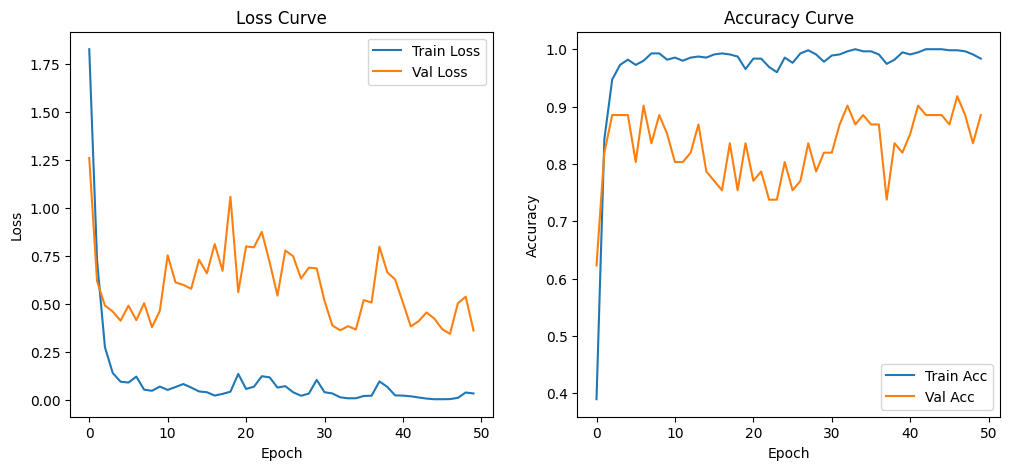

In [23]:
# ===============================================================
# 🔰 Plot Loss & Accuracy
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [24]:
# ===============================================================
# 🔰 Test evaluation
# ===============================================================
model.load_state_dict(torch.load("best_resnet50_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 79.80%
✅ Test time: 12.00 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     0.9487    0.8409    0.8916        44
Genus Helicotylenchus     0.9333    0.7636    0.8400        55
Genus Hemicycliophora     1.0000    0.5000    0.6667         2
 Genus Hirschmaniella     0.8222    0.7551    0.7872        49
    Genus Hoplolaimus     0.7397    0.9000    0.8120        60
    Genus Meloidogyne     0.9067    0.8000    0.8500        85
   Genus Pratylenchus     0.5741    0.7381    0.6458        42
     Genus Radopholus     0.6471    0.7333    0.6875        15
    Genus Trichodorus     1.0000    1.0000    1.0000        15
      Genus Xiphinema     0.6667    0.7179    0.6914        39

             accuracy                         0.7980       406
            macro avg     0.8238    0.7749    0.7872       406
         weighted avg     0.8168    0.7980    0.8022       406



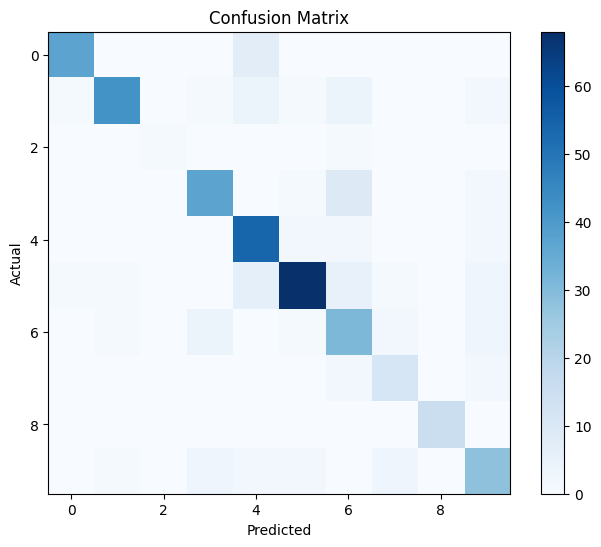


Per-class Accuracy:
Genus Criconemoides: 84.09%
Genus Helicotylenchus: 76.36%
Genus Hemicycliophora: 50.00%
Genus Hirschmaniella: 75.51%
Genus Hoplolaimus: 90.00%
Genus Meloidogyne: 80.00%
Genus Pratylenchus: 73.81%
Genus Radopholus: 73.33%
Genus Trichodorus: 100.00%
Genus Xiphinema: 71.79%


In [25]:

# ===============================================================
# 🔰 Classification report, Per-class accuracy & Confusion Matrix
# ===============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Model evaluation on test set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Only test set labels
unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# ✅ Per-class accuracy (fixed)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


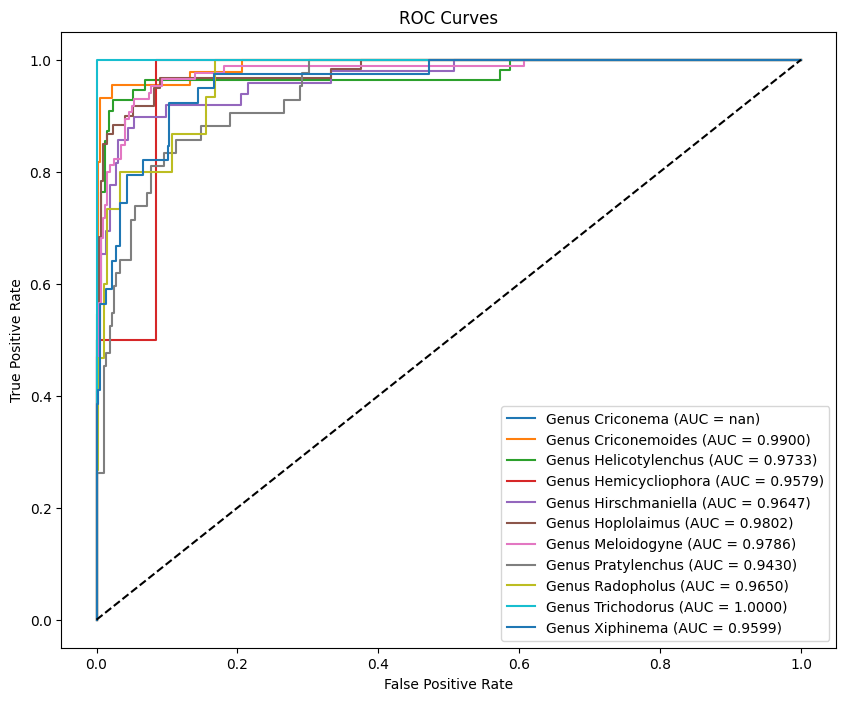

In [26]:
# ===============================================================
# 🔰 ROC-AUC per class (fixed)
# ===============================================================
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # Convert to boolean array for current class
    y_true = (all_labels_np == i).astype(int)  # 0/1 labels
    y_score = all_probs_np[:, i]               # predicted probability for class i

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [27]:
# Model GFLOPs & Params calculation
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # ResNet-50 input
flops, params = profile(model, inputs=(dummy_input,))

print(f"\n✅ Model Complexity:")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} M")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

✅ Model Complexity:
FLOPs: 4.13 GFLOPs
Parameters: 23.53 M
